In [52]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error as mae

from xgboost import XGBClassifier

In [53]:
df = pd.read_csv('invitro_train.csv')
df['Дата взятия'] = pd.to_datetime(df['Дата взятия'])
df['date'] = df['Дата взятия'].apply(lambda x: x.date())

REGIONS = sorted(df['Регион'].unique())
TEST_NAMES = sorted(df['Имя теста'].unique())
MIN_DATE = df.date.min()
MAX_DATE = df.date.max()
MAX_TRAIN_DATE = MAX_DATE - datetime.timedelta(days=19)

# COUNT_NAMES = [f'{t} count' for t in TEST_NAMES]
# POS_PERC_NAMES = [f'{t} pos perc' for t in TEST_NAMES]

In [54]:
df.head()

,Имя теста,Код теста,Значение,Регион,Дата взятия,date
0,Borrelia burgdorferi s.l (кач) ДНК,27Д,ОБНАРУЖ.,Челябинская обл,2019-05-25 06:02:00,2019-05-25
1,Borrelia burgdorferi s.l (кач) ДНК,27Д,ОБНАРУЖ.,Челябинская обл,2019-05-27 09:04:00,2019-05-27
2,Вирус клещевого энцефалита(кач) РНК,35Д,НЕ ОБНАР,Челябинская обл,2019-05-27 09:04:00,2019-05-27
3,Borrelia burgdorferi s.l (кач) ДНК,27Д,ОБНАРУЖ.,Челябинская обл,2019-05-27 09:14:00,2019-05-27
4,Вирус клещевого энцефалита(кач) РНК,35Д,НЕ ОБНАР,Челябинская обл,2019-05-27 09:14:00,2019-05-27


In [55]:
def get_pos_perc(values):
    pos = np.sum(np.isin(values, ['ОБНАРУЖ.', 'ОБНАРУЖ', 'Detected']))
    known = np.sum(np.isin(values, ['ОБНАРУЖ.', 'НЕ ОБНАР', 'ОБНАРУЖ', 'Is not detected', 'Detected']))
    return pos / known * 100

In [56]:
dates = pd.date_range(MIN_DATE, MAX_DATE, freq='1d')

data = pd.DataFrame(index=pd.MultiIndex.from_product([REGIONS, TEST_NAMES, dates], names=['Регион', 'Имя теста', 'date']))
data['count'] = 0.
data['pos_perc'] = float('nan')
data['count'].update(df.groupby(['Регион', 'Имя теста', 'date']).size())
data.pos_perc.update(df.groupby(['Регион', 'Имя теста', 'date'])['Значение'].apply(lambda x: get_pos_perc(x.values)))
data = data.reset_index()

<ipython-input-55-6865474db775>:4: RuntimeWarning: invalid value encountered in long_scalars
  return pos / known * 100


In [57]:
history = data.copy()
for i in range(1, 8):
    history['date'] = history['date'] + datetime.timedelta(days=1)
    data = data.merge(history, how='left', on=['Регион', 'Имя теста', 'date'],
                      suffixes=['', f'_{i}_days_ago'])

In [58]:
incomes = pd.read_csv('data_income.csv')[['Регион', 'Income']].drop_duplicates()
incomes['Income'] = incomes['Income'].apply(lambda x: float(''.join(x.split(' '))))
data = data.merge(incomes, how='left', on='Регион')

In [59]:
_train = data['date'] <= datetime.datetime.combine(MAX_TRAIN_DATE, datetime.time())

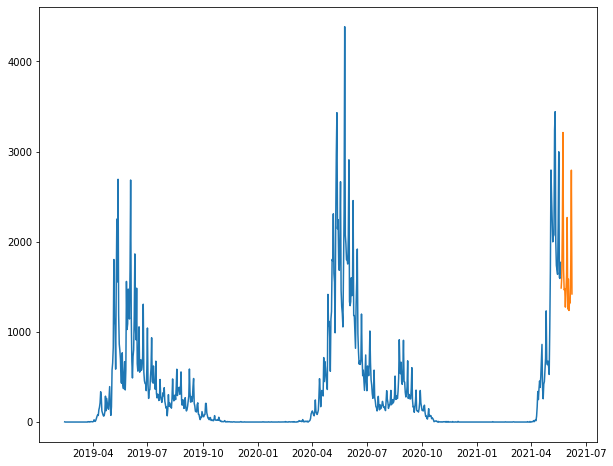

In [60]:
plt.figure(figsize=(10, 8))
plt.plot(data[_train].groupby('date')['count'].sum())
plt.plot(data[~_train].groupby('date')['count'].sum())

In [61]:
X = data.drop(['count', 'pos_perc', 'Регион', 'Имя теста', 'date'], axis=1)
y1 = data['count']
y2 = data['pos_perc']

In [18]:
xgb = XGBClassifier(n_estimators=100, max_depth=5, tree_method='gpu_hist')

In [19]:
xgb.fit(X[_train], y1[_train])

[01:39:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [39]:
data_test = data[~_train]
data_test['count_pred'] = xgb.predict(X[~_train])

<ipython-input-39-ee2447daae11>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['count_pred'] = xgb.predict(X[~_train])


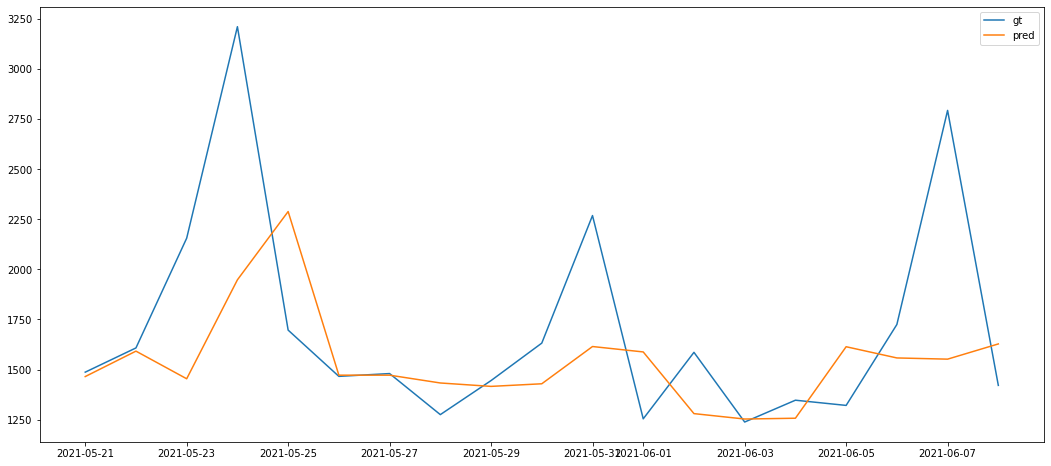

In [48]:
plt.figure(figsize=(18, 8))
plt.plot(data_test.groupby('date')['count'].sum(), label='gt')
plt.plot(data_test.groupby('date')['count_pred'].sum(), label='pred')
plt.legend()

# Submission

In [77]:
data = pd.DataFrame(index=pd.MultiIndex.from_product([REGIONS, TEST_NAMES, dates], names=['region', 'test_name', 'date']))
data['count_pred'] = 0
data['pos_perc_pred'] = 1

In [93]:
submission = pd.DataFrame()
for region in REGIONS:
    dates = pd.date_range('2021.06.09', '2021.06.27', freq='1d')
    region_submission = pd.DataFrame(index=dates)
    region_submission['region'] = region
    for test_name in TEST_NAMES:
        test_region_data = data.loc[pd.MultiIndex.from_product([[region], [test_name], dates])]
        region_submission[f'{test_name} count'] = test_region_data['count_pred'].values
        region_submission[f'{test_name} pos perc'] = test_region_data['pos_perc_pred'].values
        
    submission = submission.append(region_submission)

In [95]:
def validate_submission(submission):
    if isinstance(submission, str):
        submission = pd.read_csv(submission, index_col=0)
        
    assert submission.shape == (1273, 11), 'invalid shape'
    true_cols = [
       'region',
       'Anaplasma Phagocytophillum(кач) ДНК count',
       'Anaplasma Phagocytophillum(кач) ДНК pos perc',
       'Borrelia burgdorferi s.l (кач) ДНК count',
       'Borrelia burgdorferi s.l (кач) ДНК pos perc',
       'Borrelia miyamotoi (кач) ДНК count',
       'Borrelia miyamotoi (кач) ДНК pos perc',
       'Ehrlichia muris/chaffeеnsis(кач) ДНК count',
       'Ehrlichia muris/chaffeеnsis(кач) ДНК pos perc',
       'Вирус клещевого энцефалита(кач) РНК count',
       'Вирус клещевого энцефалита(кач) РНК pos perc']
    
    assert np.array_equal(submission.columns, true_cols), 'invalid cols'
    assert submission.isnull().sum().sum() == 0, 'null values'
    assert (submission.iloc[:, 1:] < 0).sum().sum() == 0, 'negative values'
    print('validation success')

In [96]:
validate_submission(submission)

validation success
